In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
df = pd.read_csv('carbon_dots.csv',encoding='latin1')
df.rename(columns={
    'Normal  cells (N)/cancer cells ? C?': 'CellType',
    'Human(H)/Animal(A) cells': 'Species'
}, inplace=True)

df['Particle size'] = df['Particle size'].astype(str).str.replace('nm', '', regex=False).str.strip()
df['Particle size'] = pd.to_numeric(df['Particle size'], errors='coerce')
df['Zeta potential'] = df['Zeta potential'].astype(str).str.replace('mV', '', regex=False).str.strip()
df['Zeta potential'] = pd.to_numeric(df['Zeta potential'], errors='coerce')

In [3]:
train_data = df[df['Zeta potential'].notnull()]
missing_data = df[df['Zeta potential'].isnull()]
reg = LinearRegression()
reg.fit(train_data[['Particle size', 'Exposure Dose', 'Exposure time']], train_data['Zeta potential'])
df.loc[df['Zeta potential'].isnull(), 'Zeta potential'] = reg.predict(missing_data[['Particle size', 'Exposure Dose', 'Exposure time']])
df['Viability_Class'] = df['% of cell viability'].apply(lambda x: 1 if x > 50 else 0)

In [4]:
versions = {}
for version in ['without_family', 'with_family']:
    print(f"\n{'='*25} {version.upper()} {'='*25}\n")
    use_family = version == 'with_family'
    
    features = ['Particle size', 'Extraction Solvent', 'Exposure Dose', 'Zeta potential',
                'CellType', 'Species', 'Exposure time']
    if use_family:
        features.append('Family')

    categorical_cols = ['Extraction Solvent', 'CellType', 'Species']
    if use_family:
        categorical_cols.append('Family')

    X = df[features]
    y = df['Viability_Class']

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_final = pd.concat([
        pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index),
        X.drop(columns=categorical_cols).reset_index(drop=True)
    ], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(min_samples_split=10, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    versions[version] = {
        'X_final': X_final,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'model': rf, 'y_pred': y_pred, 'y_proba': y_proba
    }


========================= WITHOUT_FAMILY =========================


========================= WITH_FAMILY =========================



In [5]:
for version in versions:
    print(f"\n--- Evaluation Metrics ({version}) ---")
    y_test = versions[version]['y_test']
    y_pred = versions[version]['y_pred']
    y_proba = versions[version]['y_proba']

    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))


--- Evaluation Metrics (without_family) ---
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.97      0.89      0.93        35

    accuracy                           0.88        42
   macro avg       0.78      0.87      0.82        42
weighted avg       0.91      0.88      0.89        42

Accuracy: 0.8809523809523809
Precision: 0.96875
Recall: 0.8857142857142857
F1 Score: 0.9253731343283582
AUC Score: 0.8632653061224489

--- Evaluation Metrics (with_family) ---
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.97      0.89      0.93        35

    accuracy                           0.88        42
   macro avg       0.78      0.87      0.82        42
weighted avg       0.91      0.88      0.89        42

Accuracy: 0.8809523809523809
Precision: 0.96875
Recall: 0.8857142857142857
F1 Score: 0.9253731343283582
AUC Score: 0.92040816


--- Confusion Matrix (without_family) ---
[[ 6  1]
 [ 4 31]]


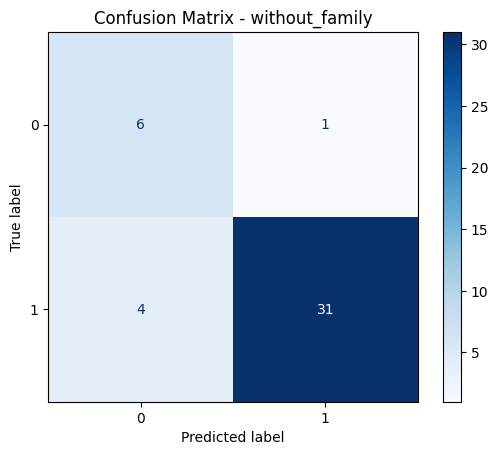


--- Confusion Matrix (with_family) ---
[[ 6  1]
 [ 4 31]]


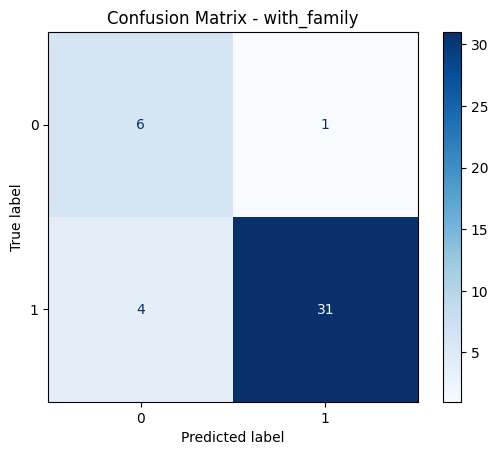

In [6]:
for version in versions:
    print(f"\n--- Confusion Matrix ({version}) ---")
    y_test = versions[version]['y_test']
    y_pred = versions[version]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {version}")
    plt.show()

In [7]:
for version in versions:
    print(f"\n--- Tuning min_samples_split ({version}) ---")
    X_train = versions[version]['X_train']
    X_test = versions[version]['X_test']
    y_train = versions[version]['y_train']
    y_test = versions[version]['y_test']

    for min_split in range(2, 21):
        clf = RandomForestClassifier(min_samples_split=min_split, random_state=42)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        print(f"min_samples_split: {min_split}, Accuracy: {acc:.4f}")


--- Tuning min_samples_split (without_family) ---
min_samples_split: 2, Accuracy: 0.8095
min_samples_split: 3, Accuracy: 0.8095
min_samples_split: 4, Accuracy: 0.8810
min_samples_split: 5, Accuracy: 0.8571
min_samples_split: 6, Accuracy: 0.8810
min_samples_split: 7, Accuracy: 0.8810
min_samples_split: 8, Accuracy: 0.8810
min_samples_split: 9, Accuracy: 0.8810
min_samples_split: 10, Accuracy: 0.8810
min_samples_split: 11, Accuracy: 0.8810
min_samples_split: 12, Accuracy: 0.8571
min_samples_split: 13, Accuracy: 0.8571
min_samples_split: 14, Accuracy: 0.8571
min_samples_split: 15, Accuracy: 0.8571
min_samples_split: 16, Accuracy: 0.8571
min_samples_split: 17, Accuracy: 0.8571
min_samples_split: 18, Accuracy: 0.8571
min_samples_split: 19, Accuracy: 0.8571
min_samples_split: 20, Accuracy: 0.8571

--- Tuning min_samples_split (with_family) ---
min_samples_split: 2, Accuracy: 0.8333
min_samples_split: 3, Accuracy: 0.8333
min_samples_split: 4, Accuracy: 0.8810
min_samples_split: 5, Accuracy: 


--- Tuning max_depth (without_family) ---
Depth: 1, Accuracy: 0.8333
Depth: 2, Accuracy: 0.8333
Depth: 3, Accuracy: 0.8333
Depth: 4, Accuracy: 0.8571
Depth: 5, Accuracy: 0.8571
Depth: 6, Accuracy: 0.8810
Depth: 7, Accuracy: 0.8810
Depth: 8, Accuracy: 0.8810
Depth: 9, Accuracy: 0.8810
Depth: 10, Accuracy: 0.8810
Depth: 11, Accuracy: 0.8810
Depth: 12, Accuracy: 0.8810
Depth: 13, Accuracy: 0.8810
Depth: 14, Accuracy: 0.8810
Depth: 15, Accuracy: 0.8810
Depth: 16, Accuracy: 0.8810
Depth: 17, Accuracy: 0.8810
Depth: 18, Accuracy: 0.8810
Depth: 19, Accuracy: 0.8810
Depth: 20, Accuracy: 0.8810


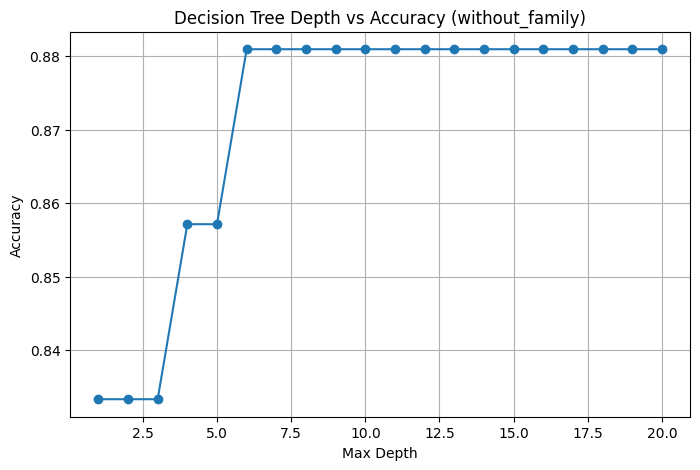


--- Tuning max_depth (with_family) ---
Depth: 1, Accuracy: 0.8333
Depth: 2, Accuracy: 0.8333
Depth: 3, Accuracy: 0.8810
Depth: 4, Accuracy: 0.8333
Depth: 5, Accuracy: 0.8810
Depth: 6, Accuracy: 0.8810
Depth: 7, Accuracy: 0.8810
Depth: 8, Accuracy: 0.8810
Depth: 9, Accuracy: 0.8810
Depth: 10, Accuracy: 0.8810
Depth: 11, Accuracy: 0.8810
Depth: 12, Accuracy: 0.8810
Depth: 13, Accuracy: 0.8810
Depth: 14, Accuracy: 0.8810
Depth: 15, Accuracy: 0.8810
Depth: 16, Accuracy: 0.8810
Depth: 17, Accuracy: 0.8810
Depth: 18, Accuracy: 0.8810
Depth: 19, Accuracy: 0.8810
Depth: 20, Accuracy: 0.8810


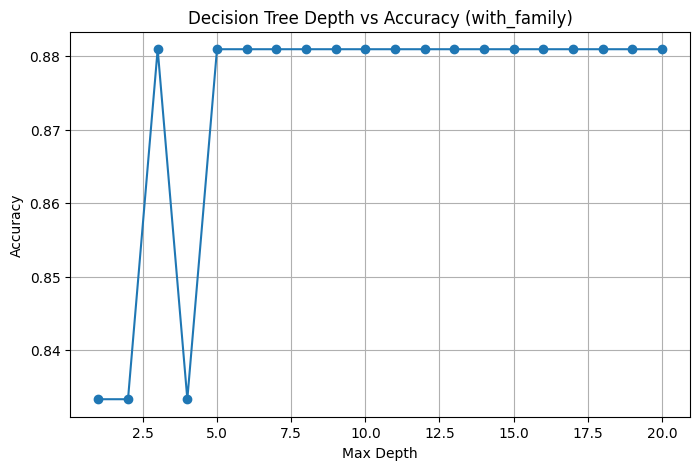

In [8]:
for version in versions:
    print(f"\n--- Tuning max_depth ({version}) ---")
    X_train = versions[version]['X_train']
    X_test = versions[version]['X_test']
    y_train = versions[version]['y_train']
    y_test = versions[version]['y_test']
    depths = list(range(1, 21))
    accuracies = []
    for depth in depths:
        clf = RandomForestClassifier(min_samples_split=10, max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        accuracies.append(acc)
        print(f"Depth: {depth}, Accuracy: {acc:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(depths, accuracies, marker='o')
    plt.title(f'Decision Tree Depth vs Accuracy ({version})')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


--- Feature Importance (without_family) ---


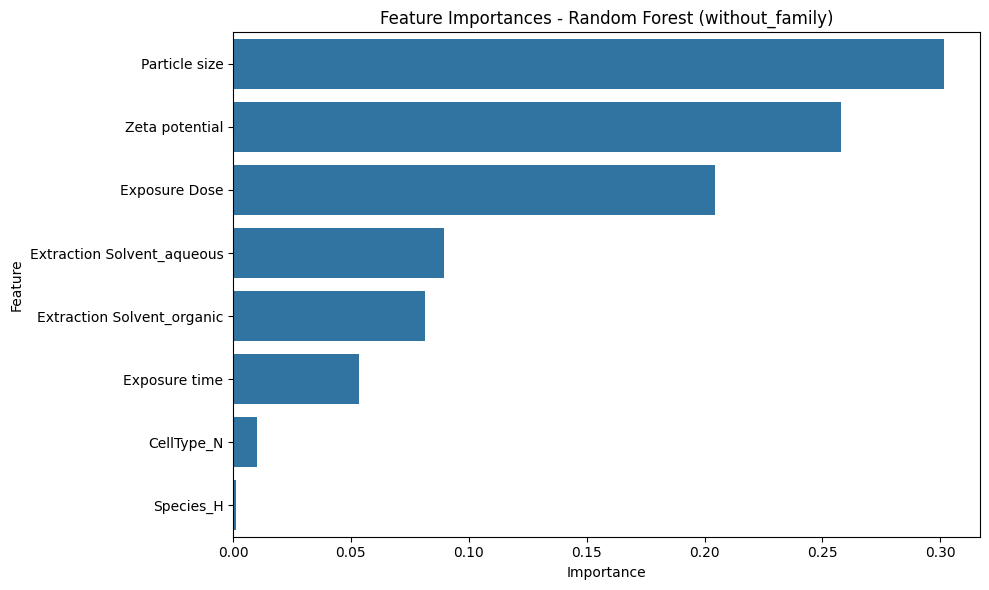


--- Feature Importance (with_family) ---


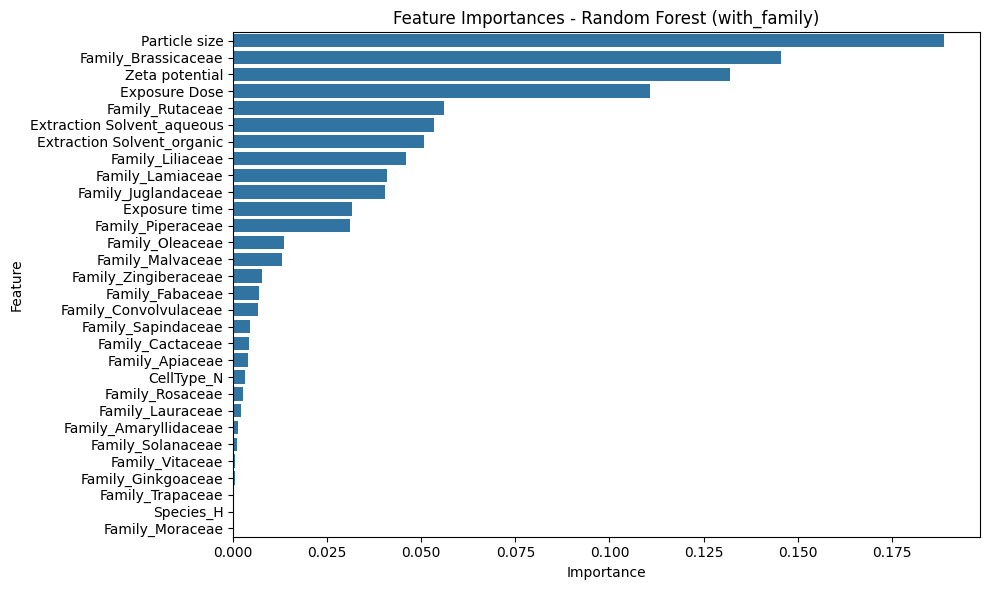

In [9]:
for version in versions:
    print(f"\n--- Feature Importance ({version}) ---")
    model = versions[version]['model']
    X_final = versions[version]['X_final']
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.array(X_final.columns)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=feature_names[indices])
    plt.title(f"Feature Importances - Random Forest ({version})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [10]:
for version in versions:
    print(f"\n--- Cross-Validation ({version}) ---")
    X_final = versions[version]['X_final']
    y = df['Viability_Class']
    cv_scores = cross_val_score(RandomForestClassifier(min_samples_split=10, random_state=42),
                                X_final, y, cv=10, scoring='accuracy')
    for i, score in enumerate(cv_scores, 1):
        print(f"Fold {i} Accuracy: {score:.4f}")
    print(f"Average Accuracy: {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation: {np.std(cv_scores):.4f}")


--- Cross-Validation (without_family) ---
Fold 1 Accuracy: 0.6190
Fold 2 Accuracy: 0.8095
Fold 3 Accuracy: 0.8095
Fold 4 Accuracy: 0.7619
Fold 5 Accuracy: 0.8571
Fold 6 Accuracy: 0.9524
Fold 7 Accuracy: 0.8571
Fold 8 Accuracy: 0.6000
Fold 9 Accuracy: 0.8500
Fold 10 Accuracy: 0.8000
Average Accuracy: 0.7917
Standard Deviation: 0.1029

--- Cross-Validation (with_family) ---
Fold 1 Accuracy: 0.6190
Fold 2 Accuracy: 0.7619
Fold 3 Accuracy: 0.6190
Fold 4 Accuracy: 0.8095
Fold 5 Accuracy: 0.8571
Fold 6 Accuracy: 1.0000
Fold 7 Accuracy: 1.0000
Fold 8 Accuracy: 0.6500
Fold 9 Accuracy: 0.8500
Fold 10 Accuracy: 0.8000
Average Accuracy: 0.7967
Standard Deviation: 0.1324
